In [1]:
from PIL import Image
import IPython.display  
import numpy as np
import matplotlib.pyplot as plt
# import PCV
import pickle
%matplotlib inline

In [2]:
menPixel=np.load('/home/ubuntu/Data/menPixel.npy')
menPixel_Gray=np.load('/home/ubuntu/Data/menPixel_Gray.npy')

In [3]:
imAdd='/Users/Shahram/Desktop/DSI/DSI_SM_01/CapStone/Data/shoe.jpeg'
pil_im = Image.open(imAdd)

IOError: [Errno 2] No such file or directory: '/Users/Shahram/Desktop/DSI/DSI_SM_01/CapStone/Data/shoe.jpeg'

In [5]:
plt.imshow(np.asarray(pil_im))

NameError: name 'pil_im' is not defined

In [6]:
T=np.asarray(pil_im)
np.shape(T)
PIXEL=0.299*T[:,:,0]+0.587*T[:,:,1]+0.114*T[:,:,2]
plt.imshow(PIXEL,cmap="gray")

NameError: name 'pil_im' is not defined

In [7]:
pil_im = Image.open(imAdd).convert('L')
pil_im.show()
# plt.imshow(np.asarray(pil_im).astype('uint8'))

IOError: [Errno 2] No such file or directory: '/Users/Shahram/Desktop/DSI/DSI_SM_01/CapStone/Data/shoe.jpeg'

In [8]:
import math

import Image
import Levenshtein


class BWImageCompare(object):
    """Compares two images (b/w)."""

    _pixel = 255
    _colour = False

    def __init__(self, imga, imgb, maxsize=64):
        """Save a copy of the image objects."""

        sizea, sizeb = imga.size, imgb.size

        newx = min(sizea[0], sizeb[0], maxsize)
        newy = min(sizea[1], sizeb[1], maxsize)

        # Rescale to a common size:
        imga = imga.resize((newx, newy), Image.BICUBIC)
        imgb = imgb.resize((newx, newy), Image.BICUBIC)

        if not self._colour:
            # Store the images in B/W Int format
            imga = imga.convert('I')
            imgb = imgb.convert('I')

        self._imga = imga
        self._imgb = imgb

        # Store the common image size
        self.x, self.y = newx, newy

    def _img_int(self, img):
        """Convert an image to a list of pixels."""

        x, y = img.size

        for i in xrange(x):
            for j in xrange(y):
                yield img.getpixel((i, j))

    @property
    def imga_int(self):
        """Return a tuple representing the first image."""

        if not hasattr(self, '_imga_int'):
            self._imga_int = tuple(self._img_int(self._imga))

        return self._imga_int

    @property
    def imgb_int(self):
        """Return a tuple representing the second image."""

        if not hasattr(self, '_imgb_int'):
            self._imgb_int = tuple(self._img_int(self._imgb))

        return self._imgb_int

    @property
    def mse(self):
        """Return the mean square error between the two images."""

        if not hasattr(self, '_mse'):
            tmp = sum((a-b)**2 for a, b in zip(self.imga_int, self.imgb_int))
            self._mse = float(tmp) / self.x / self.y

        return self._mse

    @property
    def psnr(self):
        """Calculate the peak signal-to-noise ratio."""

        if not hasattr(self, '_psnr'):
            self._psnr = 20 * math.log(self._pixel / math.sqrt(self.mse), 10)

        return self._psnr

    @property
    def nrmsd(self):
        """Calculate the normalized root mean square deviation."""

        if not hasattr(self, '_nrmsd'):
            self._nrmsd = math.sqrt(self.mse) / self._pixel

        return self._nrmsd

    @property
    def levenshtein(self):
        """Calculate the Levenshtein distance."""

        if not hasattr(self, '_lv'):
            stra = ''.join((chr(x) for x in self.imga_int))
            strb = ''.join((chr(x) for x in self.imgb_int))

            lv = Levenshtein.distance(stra, strb)

            self._lv = float(lv) / self.x / self.y

        return self._lv


class ImageCompare(BWImageCompare):
    """Compares two images (colour)."""

    _pixel = 255 ** 3
    _colour = True

    def _img_int(self, img):
        """Convert an image to a list of pixels."""

        x, y = img.size

        for i in xrange(x):
            for j in xrange(y):
                pixel = img.getpixel((i, j))
                yield pixel[0] | (pixel[1]<<8) | (pixel[2]<<16)

    @property
    def levenshtein(self):
        """Calculate the Levenshtein distance."""

        if not hasattr(self, '_lv'):
            stra_r = ''.join((chr(x>>16) for x in self.imga_int))
            strb_r = ''.join((chr(x>>16) for x in self.imgb_int))
            lv_r = Levenshtein.distance(stra_r, strb_r)

            stra_g = ''.join((chr((x>>8)&0xff) for x in self.imga_int))
            strb_g = ''.join((chr((x>>8)&0xff) for x in self.imgb_int))
            lv_g = Levenshtein.distance(stra_g, strb_g)

            stra_b = ''.join((chr(x&0xff) for x in self.imga_int))
            strb_b = ''.join((chr(x&0xff) for x in self.imgb_int))
            lv_b = Levenshtein.distance(stra_b, strb_b)

            self._lv = (lv_r + lv_g + lv_b) / 3. / self.x / self.y

        return self._lv


class FuzzyImageCompare(object):
    """Compares two images based on the previous comparison values."""

    def __init__(self, imga, imgb, lb=1, tol=15):
        """Store the images in the instance."""

        self._imga, self._imgb, self._lb, self._tol = imga, imgb, lb, tol

    def compare(self):
        """Run all the comparisons."""

        if hasattr(self, '_compare'):
            return self._compare

        lb, i = self._lb, 2

        diffs = {
            'levenshtein': [],
            'nrmsd': [],
            'psnr': [],
        }

        stop = {
            'levenshtein': False,
            'nrmsd': False,
            'psnr': False,
        }

        while not all(stop.values()):
            cmp = ImageCompare(self._imga, self._imgb, i)

            diff = diffs['levenshtein']
            if len(diff) >= lb+2 and \
                abs(diff[-1] - diff[-lb-1]) <= abs(diff[-lb-1] - diff[-lb-2]):
                stop['levenshtein'] = True
            else:
                diff.append(cmp.levenshtein)

            diff = diffs['nrmsd']
            if len(diff) >= lb+2 and \
                abs(diff[-1] - diff[-lb-1]) <= abs(diff[-lb-1] - diff[-lb-2]):
                stop['nrmsd'] = True
            else:
                diff.append(cmp.nrmsd)

            diff = diffs['psnr']
            if len(diff) >= lb+2 and \
                abs(diff[-1] - diff[-lb-1]) <= abs(diff[-lb-1] - diff[-lb-2]):
                stop['psnr'] = True
            else:
                try:
                    diff.append(cmp.psnr)
                except ZeroDivisionError:
                    diff.append(-1)  # to indicate that the images are identical

            i *= 2

        self._compare = {
            'levenshtein': 100 - diffs['levenshtein'][-1] * 100,
            'nrmsd': 100 - diffs['nrmsd'][-1] * 100,
            'psnr': diffs['psnr'][-1] == -1 and 100.0 or diffs['psnr'][-1],
        }

        return self._compare

    def similarity(self):
        """Try to calculate the image similarity."""

        cmp = self.compare()

        lnrmsd = (cmp['levenshtein'] + cmp['nrmsd']) / 2
        return lnrmsd
        return min(lnrmsd * cmp['psnr'] / self._tol, 100.0)  # TODO: fix psnr!


if __name__ == '__main__':

    import sys

    if len(sys.argv) < 3:
        print 'usage: %s image-file-1.jpg image-file-2.jpg ...' % sys.argv[0]
        sys.exit()

    tot = len(sys.argv) - 1
    tot = (tot ** 2 - tot) / 2

    print 'Comparing %d images:' % tot

    images = {}
    for img in sys.argv[1:]:
        images[img] = Image.open(img)

    results, i = {}, 1
    for namea, imga in images.items():
        for nameb, imgb in images.items():
            if namea == nameb or (nameb, namea) in results:
                continue

            print ' * %2d / %2d:' % (i, tot),
            print namea, nameb, '...',

            cmp = FuzzyImageCompare(imga, imgb)
            sim = cmp.similarity()
            results[(namea, nameb)] = sim

            print '%.2f %%' % sim

            i += 1

    res = max(results.values())
    imgs = [k for k, v in results.iteritems() if v == res][0]

    print 'Most similar images: %s %s (%.2f %%)' % (imgs[0], imgs[1], res)

ImportError: No module named Levenshtein

In [9]:
pil_im

NameError: name 'pil_im' is not defined

In [3]:
from PIL import Image
from numpy import *


def pca(X):
    """    Principal Component Analysis
        input: X, matrix with training data stored as flattened arrays in rows
        return: projection matrix (with important dimensions first), variance and mean.
    """
    
    # get dimensions
    num_data,dim = X.shape
    
    # center data
    mean_X = X.mean(axis=0)
    X = X - mean_X
    
    if dim>num_data:
        # PCA - compact trick used
        M = dot(X,X.T) # covariance matrix
        e,EV = linalg.eigh(M) # eigenvalues and eigenvectors
        tmp = dot(X.T,EV).T # this is the compact trick
        V = tmp[::-1] # reverse since last eigenvectors are the ones we want
        S = sqrt(e)[::-1] # reverse since eigenvalues are in increasing order
        for i in range(V.shape[1]):
            V[:,i] /= S
    else:
        # PCA - SVD used
        U,S,V = linalg.svd(X)
        V = V[:num_data] # only makes sense to return the first num_data
    
    # return the projection matrix, the variance and the mean
    return V,S,mean_X


def center(X):
    """    Center the square matrix X (subtract col and row means). """
    
    n,m = X.shape
    if n != m:
        raise Exception('Matrix is not square.')
    
    colsum = X.sum(axis=0) / n
    rowsum = X.sum(axis=1) / n
    totalsum = X.sum() / (n**2)
    
    #center
    Y = array([[ X[i,j]-rowsum[i]-colsum[j]+totalsum for i in range(n) ] for j in range(n)])
    
    return Y

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 9000 + 1) instead


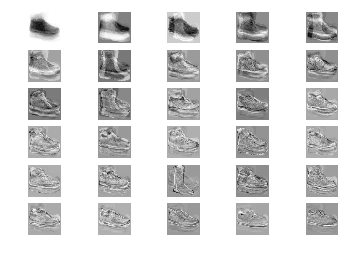

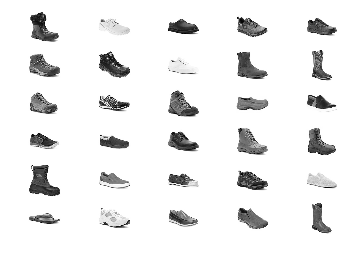

In [18]:
from PIL import Image 
from numpy import * 
from pylab import * 
import numpy 
m,n = 120,120 # get the size of the images
imnbr = 245 # get the number of images
# create matrix to store all flattened images

X=numpy.random.random_integers(0, high=9000, size=30)
Var_temp=numpy.zeros((120,120,30))
for i in range(30):
    Var_temp[:,:,i]=menPixel_Gray[:,:,X[i]]
dn=np.transpose(np.reshape(Var_temp,(120*120,30)))

immatrix = dn

# perform PCA
V,S,immean = pca(immatrix)
# show some images (mean and 7 first modes)
figure()
subplot(1,2,1)
subplot(6,5,1) 
imshow(immean.reshape(m,n),cmap='Greys_r') 
axis('off')
for i in range(0,29):
    subplot(6,5,i+2)
    imshow(((256*(V[i]-min(V[i]))/(max(V[i])-min(V[i]))).astype('uint8')
.reshape(m,n)),cmap='Greys_r')
    axis('off')
show()

subplot(1,2,2)
# subplot(6,5,1) 
# imshow(immean.reshape(m,n),cmap='Greys_r') 
axis('off')
for i in range(0,30):
    subplot(6,5,i+1)
    imshow(menPixel_Gray[:,:,X[i]],cmap='Greys_r')
    axis('off')
show()
# print np.shape(V)
# imshow((V[0].reshape(m,n)+V[1].reshape(m,n)))


(array([  2.00000000e+01,   1.54000000e+02,   6.81000000e+02,
          1.45200000e+03,   2.28300000e+03,   7.64500000e+03,
          1.49700000e+03,   5.52000000e+02,   1.10000000e+02,
          6.00000000e+00]),
 array([-0.03772331, -0.03044491, -0.02316651, -0.01588811, -0.00860971,
        -0.0013313 ,  0.0059471 ,  0.0132255 ,  0.0205039 ,  0.0277823 ,
         0.0350607 ]),
 <a list of 10 Patch objects>)

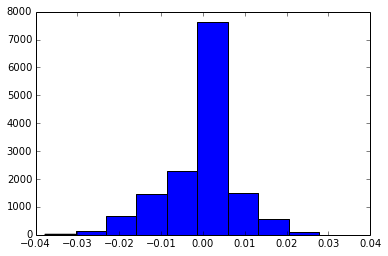

In [6]:
plt.hist(V[5])

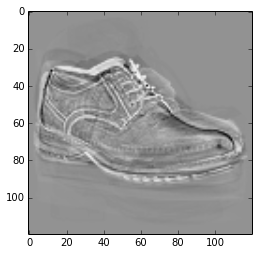

In [10]:
imshow(((256*(V[i]-min(V[i]))/(max(V[i])-min(V[i]))).astype('uint8')
.reshape(m,n)),cmap='Greys_r')

In [11]:
Z=((256*(V[i]-min(V[i]))/(max(V[i])-min(V[i]))).astype('uint8')
.reshape(m,n))

In [12]:
Z[0][0]

119

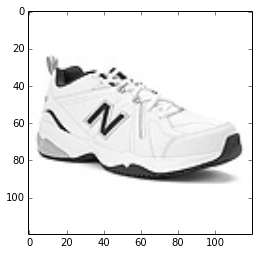

In [34]:
imshow(menPixel_Gray[:,:,1])

In [1]:
for i in range(100,115):
    subplot(4,4,i+2)
    imshow(V[i].reshape(m,n))
    axis('off')
show()

NameError: name 'subplot' is not defined

In [11]:
def multiple_image_show_gray(imL,I,J,K):
    n_rows=np.floor(np.sqrt(len(imL))).astype(int)
    temp_arr=np.concatenate( [[np.concatenate([imL[i] for i in range((j-1)*n_rows,j*n_rows)],axis=1)] for j in range(0,n_rows)],axis=1)
    plt.subplot(I,J,K)
    plt.title ("Missing " + str(int(len(imL) - n_rows*n_rows)) + " Input Image/s")
    plt.imshow(temp_arr[0,:,:].astype('uint8'),cmap="gray")
    plt.axis('off')